In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
from IPython.display import display

%matplotlib inline

import os
for dirname, _, filenames in os.walk('./input/') :
    for filename in filenames :
        print(os.path.join(dirname, filename))

./input/mitbih_database\100.csv
./input/mitbih_database\100annotations.txt
./input/mitbih_database\101.csv
./input/mitbih_database\101annotations.txt
./input/mitbih_database\102.csv
./input/mitbih_database\102annotations.txt
./input/mitbih_database\103.csv
./input/mitbih_database\103annotations.txt
./input/mitbih_database\104.csv
./input/mitbih_database\104annotations.txt
./input/mitbih_database\105.csv
./input/mitbih_database\105annotations.txt
./input/mitbih_database\106.csv
./input/mitbih_database\106annotations.txt
./input/mitbih_database\107.csv
./input/mitbih_database\107annotations.txt
./input/mitbih_database\108.csv
./input/mitbih_database\108annotations.txt
./input/mitbih_database\109.csv
./input/mitbih_database\109annotations.txt
./input/mitbih_database\111.csv
./input/mitbih_database\111annotations.txt
./input/mitbih_database\112.csv
./input/mitbih_database\112annotations.txt
./input/mitbih_database\113.csv
./input/mitbih_database\113annotations.txt
./input/mitbih_database\1

##### Default Graph 설정

In [6]:
plt.rcParams["figure.figsize"] = (30, 6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [7]:
# Train Inputs
def get_train_inputs() :
    x = tf.constant(X_train)
    y = tf.constant(y_train)
    return x, y

# Test Inputs
def get_test_inputs() :
    x = tf.constant(X_test)
    y = tf.constant(y_test)
    return x, y

# Eval data
def get_evel_data() :
    return tf.constant(X_test)

# Plot matrix
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues) :
    
    if normalize : 
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else :
        print("Confusion matrix, without normalization")
        
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
            

In [8]:
path = './input/mitbih_database/'
window_size = 100 # 160에서 변경
maximum_counting = 100000 # 10000에서 수정. 너무 큰 값이라 undersampling 한 듯.

classes = ['N', 'L', 'R', 'A', 'V', '/']
# N(Normal) = N L R
# SVEB(SupraVentricular Ectopic Beat) = A a J S e j
# VEB(Ventricular Ectopic Beat) = V E
# F(Fusion beat) = F
# Q(Unknown Beat) = P / f u
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [10]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = []
annotations = []
filenames.sort()

In [11]:
for f in filenames :
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv') :
        records.append(path + filename + file_extension)
        
    # *.txt
    else :
        annotations.append(path + filename + file_extension)

In [14]:
print(annotations[0])

./input/mitbih_database/100annotations.txt


<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-13-18de919ece03>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:


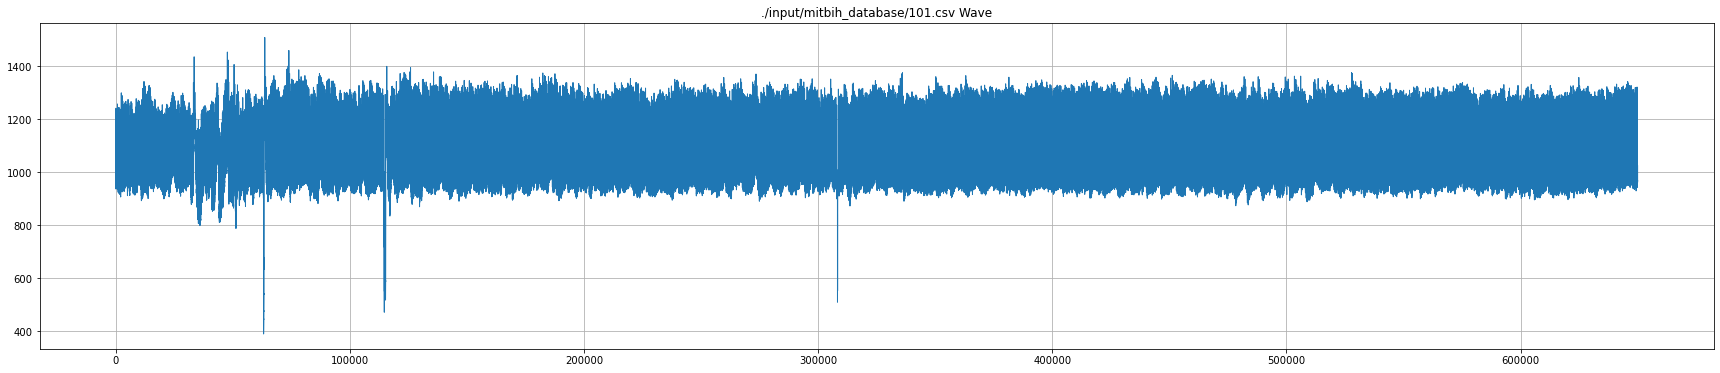

In [13]:
# Records
for r in range(0,len(records)):
# for r in range(2, 3):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals)
        plt.show()

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(signals) - window_size)):
                        beat = signals[pos-window_size+1:pos+window_size]
                        X.append(beat)
                        y.append(arrhythmia_index)

In [37]:
list0 = []
list1 = []
list2 = []
list3 = []
list4 = []
list5 = []

for i in range(107000) :
    if y[i] == 0 : # N
        list0.append(i)
    elif y[i] == 1 : # L
        list1.append(i)
    elif y[i] == 2 : # R
        list2.append(i)
    elif y[i] == 3 : # /
        list3.append(i)
    elif y[i] == 4 : # A
        list4.append(i)
    elif y[i] == 5 : # V
        list5.append(i)  
# 많은 순은 N > L > R > A > V > / 

In [38]:
print(list0) # list0 ~ list5 이런 방식으로 저장

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [ ]:
for i in list0 : # N
    plt.plot(X[i])

In [ ]:
for i in list1 : # L
    plt.plot(X[i])

In [ ]:
for i in list2 : # R
    plt.plot(X[i])

In [ ]:
for i in list3 : # /
    plt.plot(X[i])

In [ ]:
for i in list4 : # A
    plt.plot(X[i])

In [ ]:
for i in list5 : # V
    plt.plot(X[i])

In [ ]:
for i in range(0,len(X)):
    X[i].append(y[i])

print(np.shape(X))

979     804
984     776
987     775
978     773
980     767
       ... 
1373      1
1309      1
412       1
284       1
2047      1
Name: 198, Length: 889, dtype: int64


ValueError: 'label' must be of length 'x'

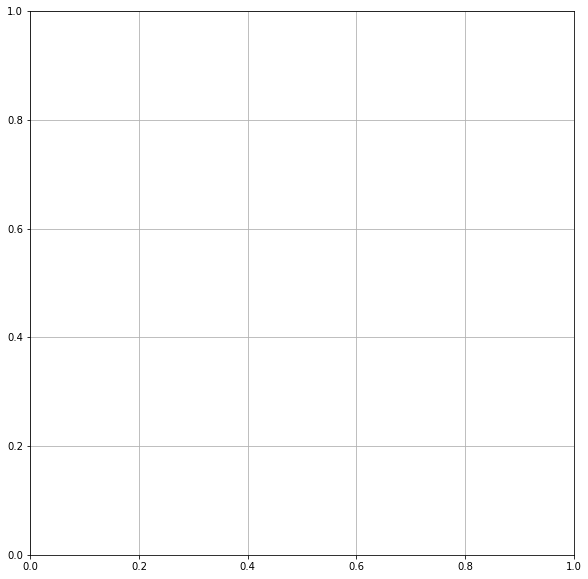

In [14]:
# representation of classes % wise
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V', '/'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green','tab:red'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
print(labels)

In [ ]:
# # plot_percentage()
# from sklearn.utils import resample

# df_1=X_train_df[X_train_df[319]==1]
# df_2=X_train_df[X_train_df[319]==2]
# df_3=X_train_df[X_train_df[319]==3]
# df_4=X_train_df[X_train_df[319]==4]
# df_5=X_train_df[X_train_df[319]==5]
# df_0=(X_train_df[X_train_df[319]==0]).sample(n=5000,random_state=42)

# df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
# df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
# df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
# df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])

In [ ]:
# per_class = X_train_df[319].value_counts()
# print(per_class)
# plt.figure(figsize=(20,10))
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V', '/'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green','tab:red'],autopct='%1.1f%%')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()

In [15]:
# Train Test Split
train, test = train_test_split(X_train_df, test_size = 0.20)

print("X_train : ", len(train))
print("X_test : ", len(test))

X_train :  85647
X_test :  21412


In [16]:
target_train = train[train.shape[1] - 1]
target_test = test[test.shape[1] - 1]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(85647, 2048) (21412, 1589)


In [17]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(X_train))

(85647, 198, 1)


In [18]:
X_train.shape[1]

198

In [19]:
# Network
def network(X_train, y_train, X_test, y_test) :
    im_shape = (X_train.shape[1], 1)
    
    inputs_cnn = Input(shape = (im_shape), name = 'inputs_cnn')
    # convolutional layer 1
    conv1_1 = Convolution1D(64, (6), activation = 'elu', input_shape = im_shape)(inputs_cnn)
    conv1_1 = BatchNormalization()(conv1_1)
    # pooling layer 1
    pool1 = MaxPool1D(pool_size = (3), strides = (2), padding = "same")(conv1_1)
    # convolutional layer 2
    conv2_1 = Convolution1D(128, (3), activation = 'elu', input_shape = im_shape)(pool1)
    conv2_1 = BatchNormalization()(conv2_1)
    # convolutional layer 3
    conv3_1 = Convolution1D(128, (3), activation = 'elu', input_shape = im_shape)(conv2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    # pooling layer 2
    pool2 = MaxPool1D(pool_size = (2), strides = (2), padding = 'same')(conv3_1)
    # convolutional layer 4
    conv4_1 = Convolution1D(256, (3), activation = 'elu', input_shape = im_shape)(pool2)
    conv4_1 = BatchNormalization()(conv4_1)
    # convolution layer 5
    conv5_1 = Convolution1D(256, (3), activation = 'elu', input_shape = im_shape)(conv4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    # pooling layer 3
    pool3 = MaxPool1D(pool_size = (2), strides = (2), padding = "same")(conv5_1)
    # flattened layer 1
    flatten = Flatten()(pool3)
    # dense layer
    dense_end1 = Dense(1024, activation = 'elu')(flatten)
    
    main_output = Dense(6, activation = 'softmax', name = 'main_output')(dense_end1)
    
    model = Model(inputs = inputs_cnn, outputs = main_output)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', precision, recall, f1score])
    
    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 8), ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_loss', save_best_only = True)]
    
    history = model.fit(X_train, y_train, epochs = 5, callbacks = callbacks, batch_size = 32, validation_data = (X_test, y_test))
    model.load_weights('best_model.h5')
    return(model, history)
    

In [20]:
def evaluate_model(history, X_test, y_test, model) :
    scores = model.evaluate((X_test), y_test, verbose = 0)
    print("Accuracy : %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc = 'lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc = 'upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_name = ['0', '1', '2', '3', '4', '5']
    
    y_true = []
    for element in y_test :
        y_true.append(np.argmax(element))
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis = 1)
    cnf_matrix = confusion_matrix(y_true, prediction)  

In [21]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model, history = network(X_train, y_train, X_test, y_test)

NameError: name 'precision' is not defined

In [22]:
evaluate_model(history, X_test, y_test, model)
y_pred = model.predict(X_test)

NameError: name 'history' is not defined

In [23]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues) :
    if normalize :
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        


Normalized confusion matrix


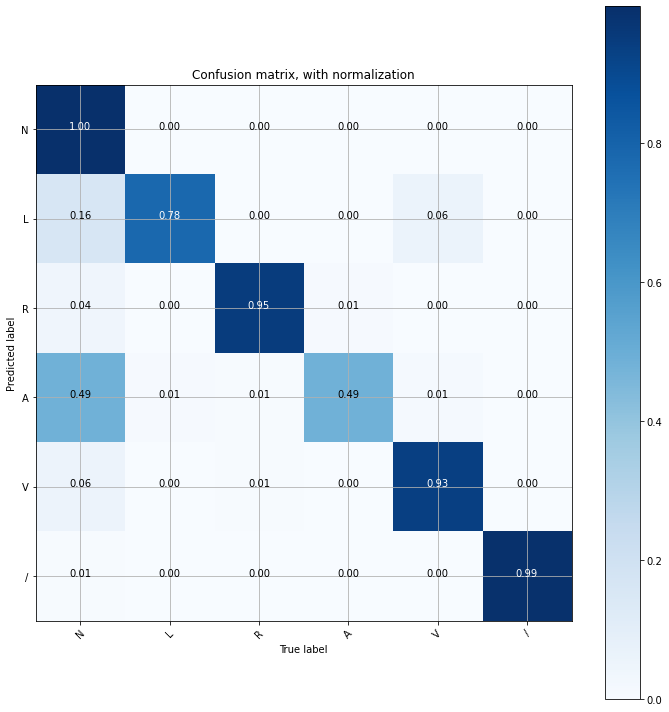

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
np.set_printoptions(precision = 2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = ['N', 'L', 'R', 'A', 'V', '/'], normalize = True, title = 'Confusion matrix, with normalization')
plt.show()